# Decoding Neural Signals with Hybrid Quantum LSTMs

## Introduction

Inspired by advances in neuroscience and related recording technology, the [Neural Latents Benchmark Challenge](https://neurallatents.github.io/) (NLB) released datasets and a Machine Learning Challenge for the Neuroscience community in 2021. 

In this project, I continue work on the NLB dataset by exploring the intersection between Hybrid Quantum ML and Neural Decoding. In particular, I use Quantum LSTM architecture to predict the hand movement of a macaque monkey, given electrophysiological measurements recorded using intracortical microelectrode arrays. 

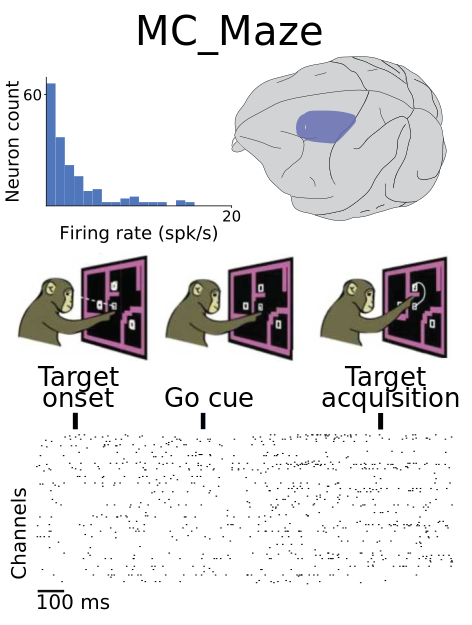

In [1]:
from IPython.display import display, Image
display(Image(filename="images/maze_fig1.png", embed=True))

## About the Data

The dataset was provided by Krishna Shenoy, Mark Churchland, and Matt Kaufman from Stanford University, and you can learn more about the task design, data collection, and their analyses of the data in a number of papers, including [this](https://pubmed.ncbi.nlm.nih.gov/21040842/) (Churchland et al. 2010). 

Neural Latents Benchmark ([NLB](https://neurallatents.github.io/))<a name="citenlb"></a>[<sup>1</sup>](#footnotenlb)

This project is concerned exclusively with the [MC_Maze](https://neurallatents.github.io/datasets#mcmaze) dataset. NLB provided a demo of this dataset [here](https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_maze.ipynb). In short, a monkey with a brain implant views a screen, and is instructed to move a digital cursor through a simple maze. Each electrode on the implant records neural activity, measured by proximate spikes in voltage. These spikes in activity can be used to predict the actual movement that the monkey performed.

<a name="footnotenlb"></a>[1.](#citenlb) *Neural Latents Benchmark '21: Evaluating latent variable models of neural population activity*, Felix Pei and Joel Ye and David M. Zoltowski and Anqi Wu and Raeed H. Chowdhury and Hansem Sohn and Joseph E. O'Doherty and Krishna V. Shenoy and Matthew T. Kaufman and Mark Churchland and Mehrdad Jazayeri and Lee E. Miller and Jonathan Pillow and Il Memming Park and Eva L. Dyer and Chethan Pandarinath

### Download Data if necessary

In [2]:
# # Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000128
# # In the above, replace the dandiset ID with the one you want to download.
# # For convenience, I have included the smallest version of the dataset in the data folder of this repo

### Imports & Load Data

In [3]:
# Standard imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

# modelling
from torch.utils.data import DataLoader
import torch
from TSModels import SequenceDataset, ShallowRegressionLSTM, QLSTM, QShallowRegressionLSTM

# NLB specifics
from nlb_tools.nwb_interface import NWBDataset

#eval
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [4]:
dataset_name = "mc_maze_small" 

datanames = {
    'mc_maze' : '000128',
    'mc_maze_large' : '000138',
    'mc_maze_small' : '000140',
}
fp = f"data/{datanames[dataset_name]}/sub-Jenkins/"

In [5]:
dataset = NWBDataset(fp, 
    "*train" , split_heldout=False
    )
dataset.data.shape

(293666, 150)

## Preprocessing

The raw data measures neural spikes recorded each millisecond, but NLB suggests re-binning the data into either 5ms or 20ms bins. Here, we'll use 20ms bins. 

In [6]:
print(dataset.bin_width)
dataset.resample(20)
print(dataset.bin_width)

1
20


Additionally, we must consider the delay between neural activation, and the actual physical reaction of the monkey's hand. NLB recommends an 80ms delay, such that if a neural spike indicates hand movement, we'd expect to see the neural activity 80ms prior to when the actual movement is observed. 

In [7]:
# here, we offset our inputs and target variables with an 80ms difference
# Extract neural data and lagged hand velocity
baseline_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-130, 370))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450))

# Define X and Y from these dataframes, temporarily including trial id on X
xcols = [x for x in baseline_trial_data.columns if x[0] == 'spikes']
X = baseline_trial_data[xcols+[('trial_id','')]].copy()
print(f"X shape: {X.shape}")

Y = lagged_trial_data[[('hand_vel','x'),('hand_vel','y')]].copy()
print(f"Y shape: {Y.shape}")

X shape: (2500, 143)
Y shape: (2500, 2)


The next preprocessing steps must be done after the test/train split:

In [8]:
test_pct = .3
cutoff = len(X) * (1 - test_pct)
cutoff = int(cutoff)

X_train, X_test = X[:cutoff].copy(), X[cutoff:].copy()
Y_train, Y_test = Y[:cutoff].copy(), Y[cutoff:].copy()

To validate that this split is valid, we ensure that no specific trial has readings on both train and test. Each trial should be exclusively in one or the other: 

In [9]:
# should be an empty set
set(X_train['trial_id']).intersection(set(X_test['trial_id']))

set()

In [10]:
#now we can safely drop the trial id
X_train.drop(('trial_id',''), axis=1, inplace=True)
X_test.drop(('trial_id',''), axis=1, inplace=True)

In [11]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1750, 142), (750, 142), (1750, 2), (750, 2))

In [12]:
# flatten the column index for the Y data
Y_train.columns = ['hand_vel_x', 'hand_vel_y']
Y_test.columns = ['hand_vel_x', 'hand_vel_y']

In [13]:
traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)
traindf.shape, testdf.shape

/var/folders/9j/vq3r860d6g528nr3x98p0gdh0000gn/T/ipykernel_66380/911231013.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
/var/folders/9j/vq3r860d6g528nr3x98p0gdh0000gn/T/ipykernel_66380/911231013.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)


((1750, 144), (750, 144))

# Modelling Helper Functions

In [14]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# Modelling -- Classical LSTM

Training: For simplicity I will focus on predicting just the X-dimension

In [15]:
torch.manual_seed(101)
batch_size = 1
sequence_length = 4

target = 'hand_vel_x'
features = [x for x in traindf.columns if x not in ('hand_vel_x', 'hand_vel_y')]

train_dataset = SequenceDataset(
    traindf,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    testdf,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 4, 142])
Target shape: torch.Size([1])


In [17]:
# in general, parameters are chosen to be equivalent to what 
# is used in the Quantum version later in this notebook, to provide a fair comparison
learning_rate = 0.0005
num_hidden_units = 32

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)

classical_loss_test.append(test_loss)
epochs = 20
for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 114139.84281055466
Epoch 0
---------
Train loss: 127575.8512945022
Test loss: 105837.62218483396

Epoch 1
---------
Train loss: 116707.72424795305
Test loss: 97230.68963896058

Epoch 2
---------
Train loss: 107732.74219389324
Test loss: 90858.62742234548

Epoch 3
---------
Train loss: 99558.08320182524
Test loss: 84563.53316081913

Epoch 4
---------
Train loss: 91637.99060395229
Test loss: 78754.88175626584

Epoch 5
---------
Train loss: 83688.46809956373
Test loss: 74732.78960500447

Epoch 6
---------
Train loss: 75388.85248311088
Test loss: 69814.43668271798

Epoch 7
---------
Train loss: 67796.93026586401
Test loss: 67191.4258634534

Epoch 8
---------
Train loss: 60855.88515292694
Test loss: 63661.20369465266

Epoch 9
---------
Train loss: 54225.28598000159
Test loss: 61512.456757888474

Epoch 10
---------
Train loss: 48316.42860090709
Test loss: 61346.1847125901

Epoch 11
---------
Train loss: 43006.41494370612
Test loss: 58564.65765979654

Epoch 

In [19]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = ("Model forecast",'')
traindf[ystar_col] = predict(train_eval_loader, model).numpy()
testdf[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((traindf, testdf))[[target, ystar_col]]

/Users/gregcondit/miniconda3/envs/qenv/lib/python3.10/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


### Evaluating the Classical Model

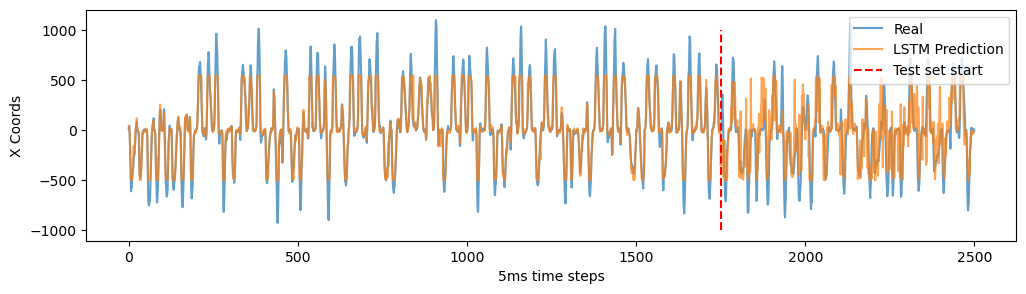

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(range(len(df_out)), df_out[target], label = "Real", alpha = .7)
plt.plot(range(len(df_out)), df_out[ystar_col], label = "LSTM Prediction", alpha = .7)
plt.ylabel('X Coords')
plt.xlabel('5ms time steps')
plt.vlines(len(df_out) * (1 - test_pct), ymin = -1000, ymax = 1000, label = "Test set start", linestyles = "dashed",
          colors = "red")
plt.legend()
plt.show()

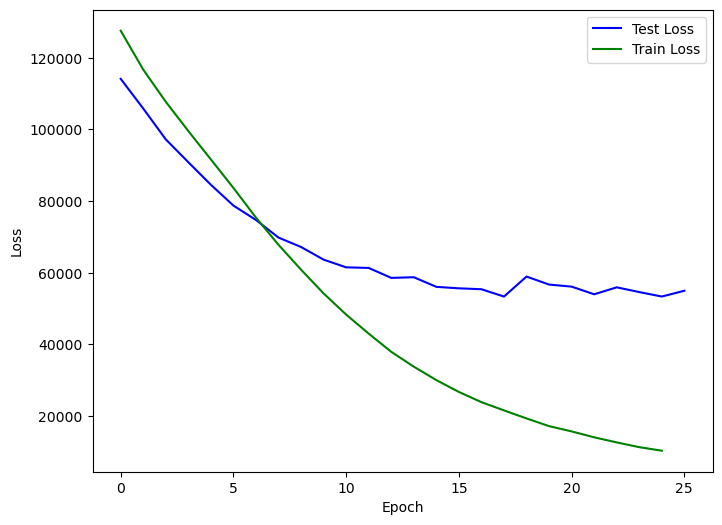

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(classical_loss_test)), classical_loss_test, color = "blue")
plt.plot(range(len(classical_loss_train)), classical_loss_train, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Test Loss", "Train Loss"])
plt.show()

In [22]:
r2 = r2_score(testdf[target], testdf[ystar_col])
corr, _ = pearsonr(testdf[target], testdf[ystar_col])

print(f"R2: {round(r2,2)}")
print(f"Pearson correlation: {round(corr,2)}")

R2: 0.5
Pearson correlation: 0.72


# Modelling -- Quantum LSTM

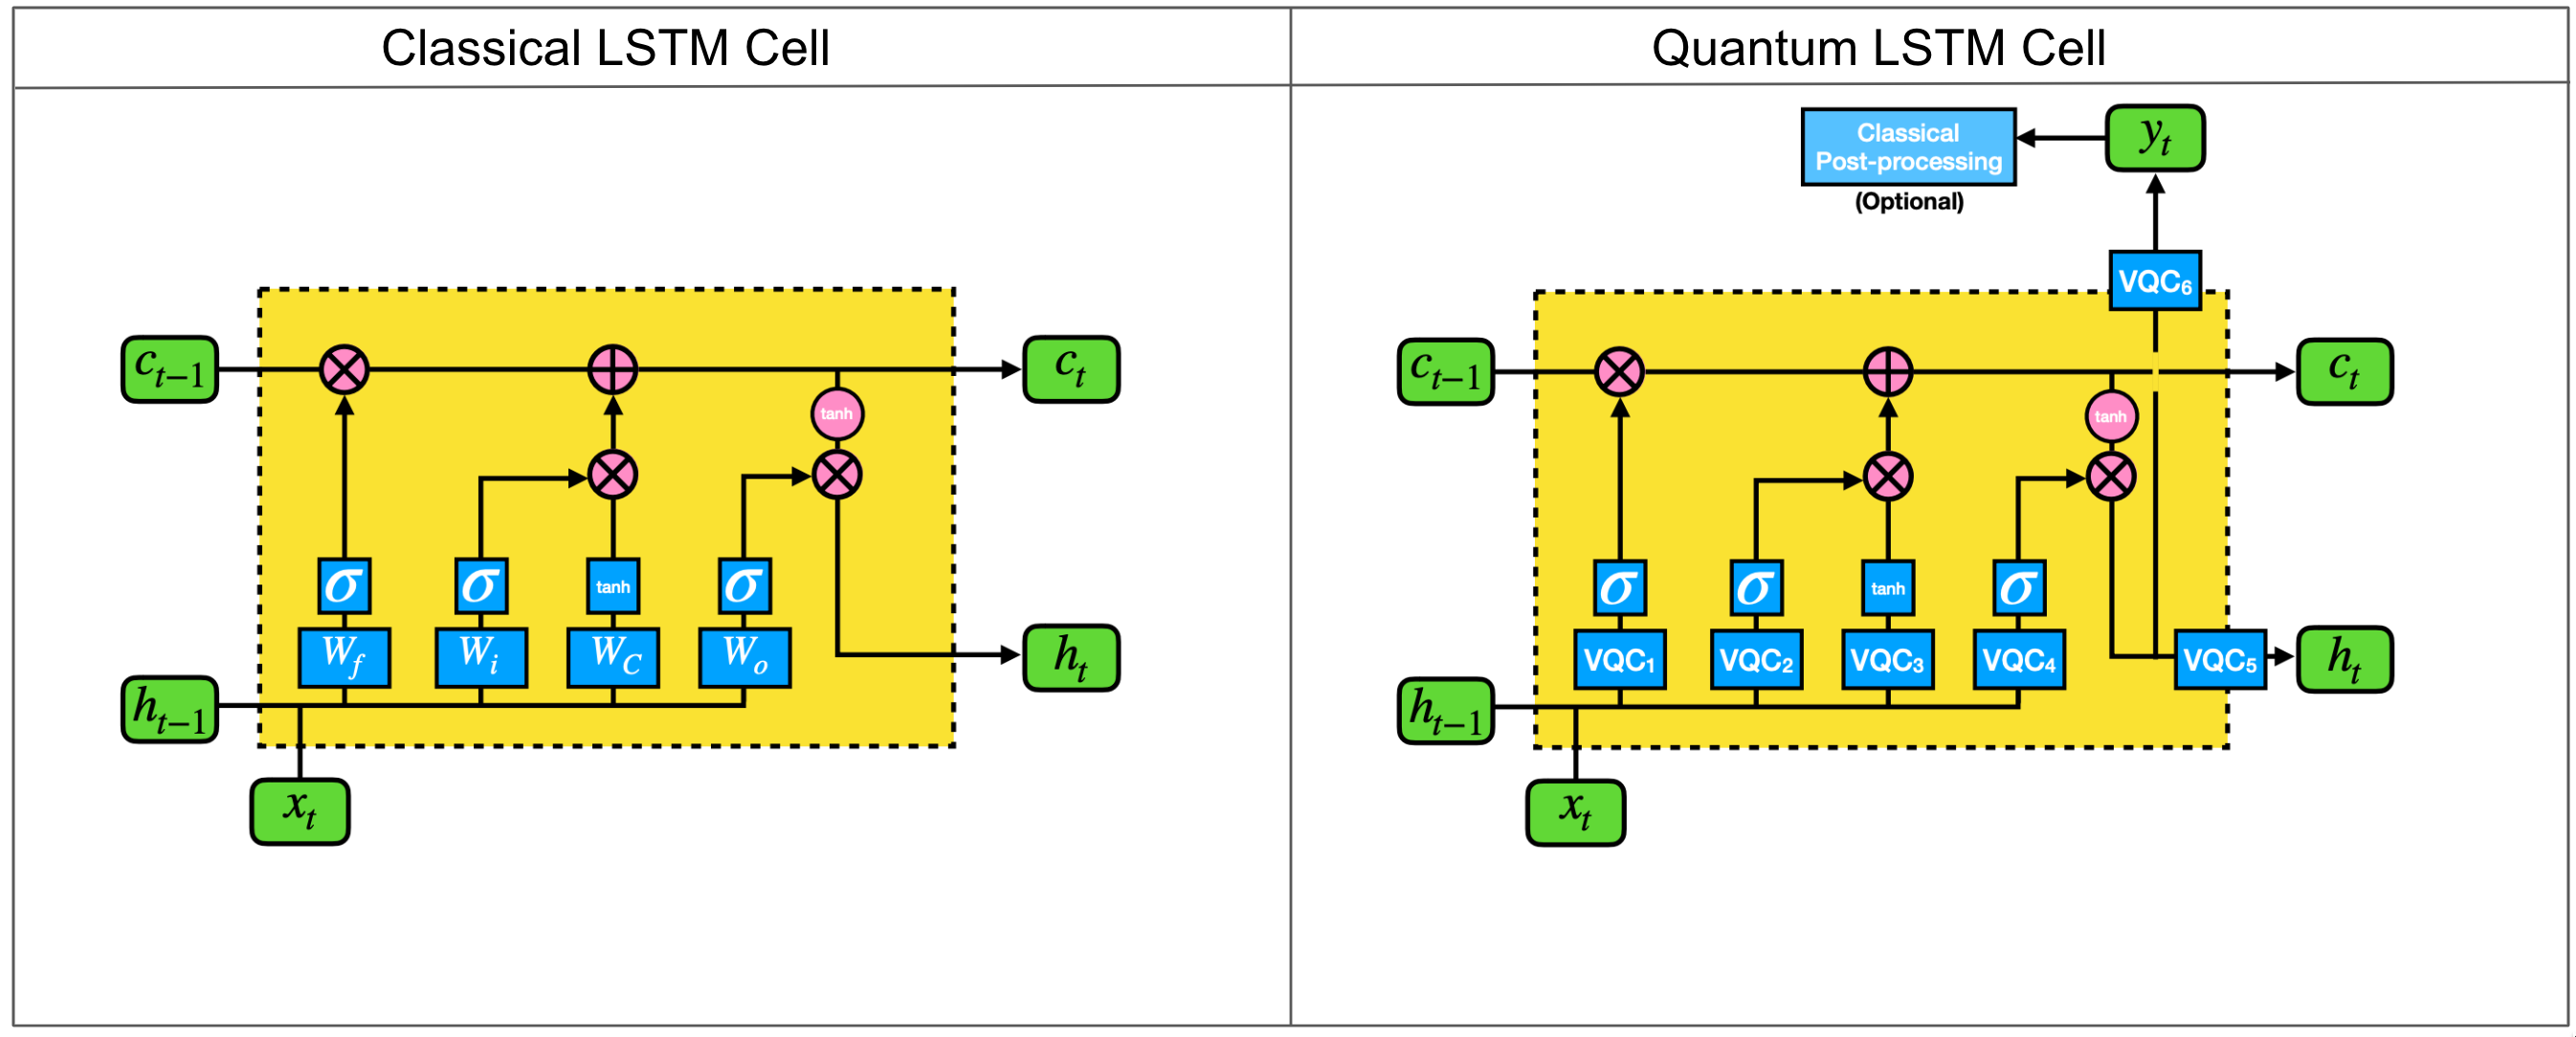

In [23]:
display(Image(filename='images/LSTM-diagram.png'))

*Image credit to Samuel Yen-Chi Chen, Shinjae Yoo, Yao-Lung L. Fang (https://arxiv.org/abs/2009.01783)*

As seen in the above diagram, in a Quantum LSTM, the tunable weight matrices are replaced by Variational Quantum Circuits (VQC). VQCs are quantum circuits with learnable rotation parameters. VQCs are small in circuit size, and qubit errors can be corrected during optimization, making them viable learners in the NISQ era. You can learn more about VQCs [here](https://pennylane.ai/qml/glossary/variational_circuit.html#variational-circuits). 

In [24]:
traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)

/var/folders/9j/vq3r860d6g528nr3x98p0gdh0000gn/T/ipykernel_66380/30644356.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
/var/folders/9j/vq3r860d6g528nr3x98p0gdh0000gn/T/ipykernel_66380/30644356.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)


In [25]:
train_dataset = SequenceDataset(
    traindf,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    testdf,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [26]:
torch.manual_seed(101)

batch_size = 1
# we'll start by looking back 4 time steps, which is 20 ms
sequence_length = 4

In [27]:
target = 'hand_vel_x'
features = [x for x in traindf.columns if x not in ('hand_vel_x', 'hand_vel_y')]


train_dataset = SequenceDataset(
    traindf,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    testdf,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 4, 142])
Target shape: torch.Size([1])


In [29]:
learning_rate = 0.05 # with fewer parameters, we can afford a higher learning rate
num_hidden_units = 32

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=8)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 8)


In [30]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Test loss: 114158.34258987418
Execution time 103.82147812843323
Epoch 0
---------
Train loss: 124003.0916995461
Test loss: 99275.62131505553
Execution time 618.9176743030548
Epoch 1
---------
Train loss: 108412.38223821754
Test loss: 90005.83474878069
Execution time 630.4168980121613
Epoch 2
---------
Train loss: 98146.76575391094
Test loss: 84585.0855639635
Execution time 632.3371860980988
Epoch 3
---------
Train loss: 91023.54494606341
Test loss: 80579.7678851601
Execution time 623.3138270378113
Epoch 4
---------
Train loss: 85230.54952583124
Test loss: 77626.37810953952
Execution time 627.9441859722137
Epoch 5
---------
Train loss: 80052.10157965751
Test loss: 75452.66480581029
Execution time 632.3419411182404
Epoch 6
---------
Train loss: 75565.05608118733
Test loss: 73255.94269873587
Execution time 618.5660181045532
Epoch 7
---------
Train loss: 71422.50406871698
Test loss: 73500.61884086787
Execution time 622.7913789749146
Epoch 8
---------
Train loss: 679

In [31]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
traindf[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
testdf[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

In [32]:
df_out_Q = pd.concat((traindf, testdf))[[target, ystar_col_Q]]

print(df_out_Q.head())

   hand_vel_x  Model forecast
0    9.749481        2.802975
1   31.199101       33.927837
2   41.501937       22.759005
3  -41.959898      -82.347313
4 -172.545916      -93.445152


### Evaluating the Hybrid Model

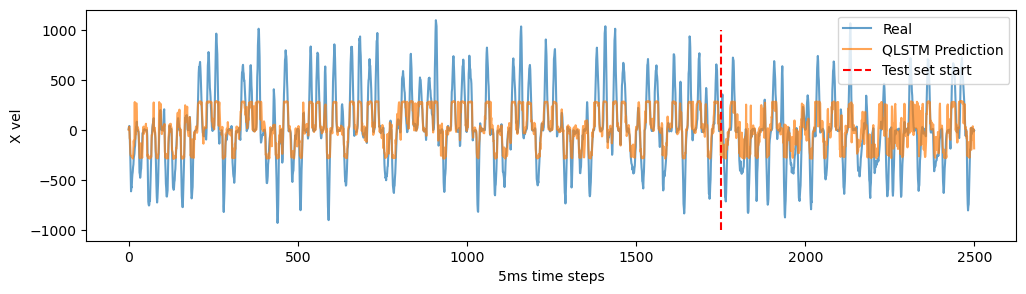

In [33]:
plt.figure(figsize=(12, 3))
plt.plot(range(len(df_out_Q)), df_out_Q[target], label = "Real", alpha = .7)
plt.plot(range(len(df_out_Q)), df_out_Q[ystar_col_Q], label = "QLSTM Prediction", alpha = .7)
plt.ylabel('X vel')
plt.xlabel('5ms time steps')
plt.vlines(len(df_out_Q) * (1 - test_pct), ymin = -1000, ymax = 1000, label = "Test set start", linestyles = "dashed",
          colors = "red")
plt.legend()
plt.show()

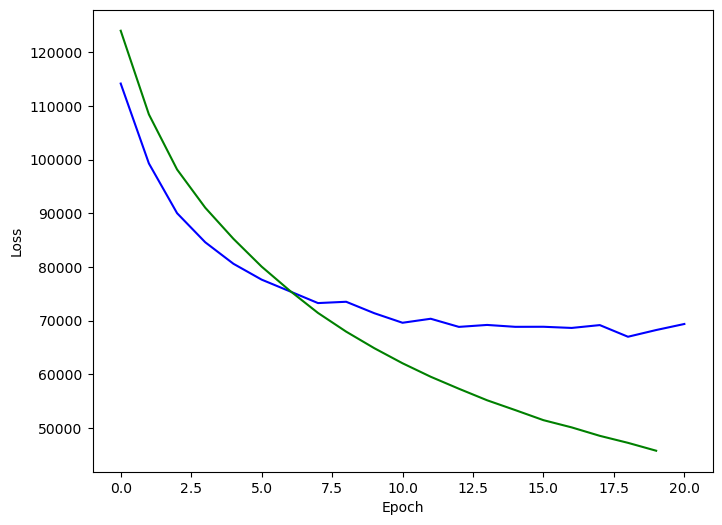

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
plt.plot(range(len(quantum_loss_train)), quantum_loss_train, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [36]:
r2 = r2_score(testdf[target], testdf[ystar_col_Q])
print(f"R2: {round(r2,2)}")


R2: 0.37


# Comparing the Classical & Hybrid Models